In [ ]:
!nvidia-smi 

In [ ]:
!pip uninstall keras-nightly
!pip install h5py==2.10.0

## Creacion y Entrenamiento Modelo


#### DownGrade tensorflow y keras

In [ ]:
!pip install tensorflow==1.15.4
!pip install keras==2.2.4


In [ ]:
import keras
print(keras.__version__)

In [ ]:
import tensorflow as tf
print(tf.__version__)

#### Acceso a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Importacion y configuracion de librerias

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import json
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
from skimage.transform import rescale, resize

#from scipy.misc import imsave

#hide warnings 
import warnings
warnings.filterwarnings('ignore')

# Root directory of the project
ROOT_DIR = os.path.abspath("drive/My Drive/..")
print(ROOT_DIR)

In [ ]:
# Import Mask RCNN
MaskRCNNPath=os.path.join(ROOT_DIR,"Mask_RCNN")
sys.path.append(MaskRCNNPath)  # To find local version of the library

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR,"Coco_Model","mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#### Configuracion (Funciones) de la arquitectura y dataset

In [ ]:
class FridgeConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fridge"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3

    # Number of classes (including background)
    NUM_CLASSES = 2 + 1 # background + 5 fridge

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 11

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 3

    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"


    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64


    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400

    
config = FridgeConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
class FridgeDataset(utils.Dataset):

    def load_fridge(self, dataset_dir, subset):
        """Load a subset of the fridge dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("fridge", 1, "Fibroblast")
        self.add_class("fridge", 2, "Odontoblast")
#        self.add_class("fridge", 3, "Person")
#        self.add_class("fridge", 4, "FridgeBack")
#        self.add_class("fridge", 5, "FridgeSide")
        

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir,"via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        print(len(annotations))
        b = annotations[0]
        c = b['regions'][0]
        print(c['shape_attributes'])
        
        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            classids = [t['Cell'] for t in polygons]
            classids=list(filter(None, classids))
            #polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #polygons = []
            #classids = []
            class_Ids = []
            #counter = 0
            #for i in a['regions']:
            #    counter += 1
                
            
            for i, p in enumerate(classids):
                val = 0
                if p == 'Fibroblast':
                    val = 1
                if p == 'Odontoblast':
                    val = 2
                #if p['Class'] == 'Person':
                #    val = 3
                #if p['Class'] == 'FridgeBack':
                #    val = 4
                #if p['Class'] == 'FridgeSide':
                #    val = 5
                class_Ids.append(val)
    
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.

            hh=512
            ww=512
            cc=3

            image_path = os.path.join(dataset_dir, a['filename'])
            or_image = skimage.io.imread(image_path)
            [h,w,c]=or_image.shape

            # compute center offset
            xx = (ww - w) // 2
            yy = (hh - h) // 2

            padd_image = 255*np.ones((hh,ww,cc), dtype=np.uint8)
            padd_image[yy:yy+h,xx:xx+w,]=or_image.copy()
            
            height, width = padd_image.shape[:2]
            print('Before: ', or_image.shape[:2])
            factorscaleWidth = 512.0/w
            factorscaleHeight = 512.0/h
            image = resize(padd_image, (round(factorscaleHeight*h), round(factorscaleWidth*w)))
            
            height, width = image.shape[:2]
            a['filename'] = str('resized') + a['filename']
            image_path = os.path.join(dataset_dir,a['filename'])
            skimage.io.imsave(image_path, image)
            print('After: ', image.shape[:2])

            self.add_image(
                "fridge",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                factorscaleWidth=factorscaleWidth,
                factorscaleHeight=factorscaleHeight,
                catIds=class_Ids)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        shapes = info['catIds']
        factorscaleWidth = info['factorscaleWidth']
        factorscaleHeight = info['factorscaleHeight']
        count = len(shapes)
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            x = p['all_points_x']
            y = p['all_points_y']
            xx = []
            yy = []
            for k in range(len(x)):
                xx.append(round(factorscaleWidth*x[k]))
            for k in range(len(y)):
                yy.append(round(y[k]+64))
            #print(x)
            rr, cc = skimage.draw.polygon(yy, xx)
            mask[rr, cc, i] = 1
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        
        # Map class names to class IDs.
        class_ids = np.array(shapes)
        return mask, class_ids.astype(np.int32)      

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fridge":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
"""Train the model."""
# Training dataset.
dataset_train = FridgeDataset()
dataset_train.load_fridge(ROOT_DIR+"/dataset/", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = FridgeDataset()
dataset_val.load_fridge(ROOT_DIR+"/dataset", "val")
dataset_val.prepare()

(512, 512, 3)
(512, 512, 20)
0


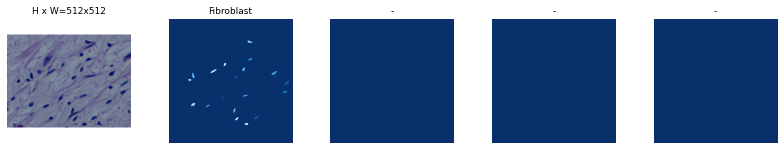

(512, 512, 3)
(512, 512, 16)
1


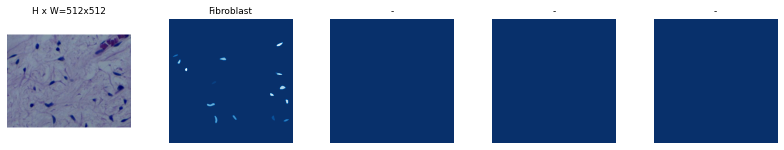

(512, 512, 3)
(512, 512, 19)
2


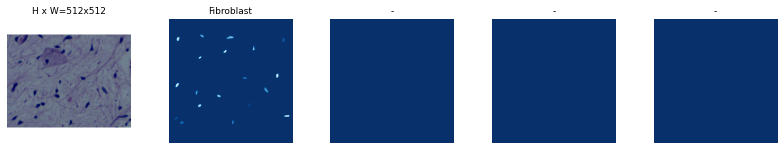

(512, 512, 3)
(512, 512, 11)
3


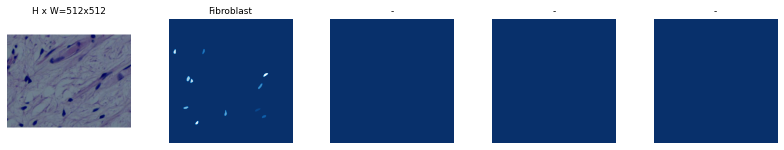

(512, 512, 3)
(512, 512, 23)
4


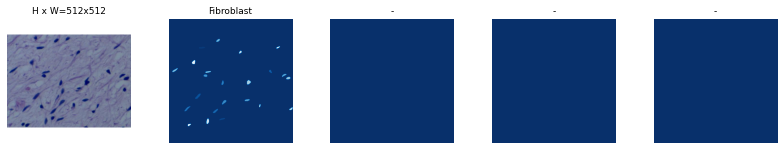

(512, 512, 3)
(512, 512, 24)
5


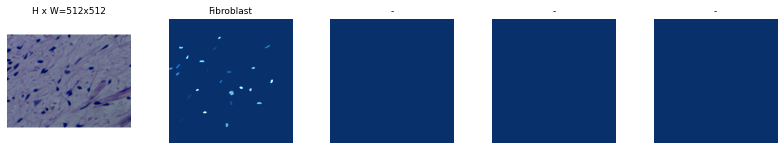

(512, 512, 3)
(512, 512, 18)
6


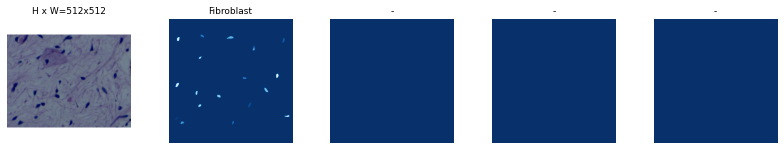

(512, 512, 3)
(512, 512, 14)
7


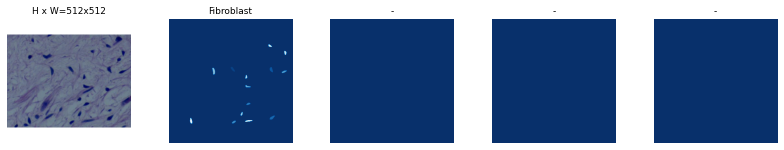

(512, 512, 3)
(512, 512, 25)
8


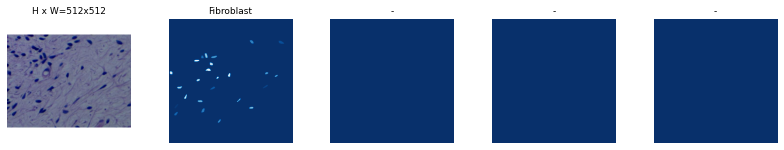

(512, 512, 3)
(512, 512, 31)
9


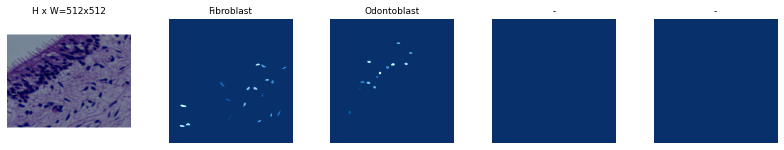

(512, 512, 3)
(512, 512, 46)
10


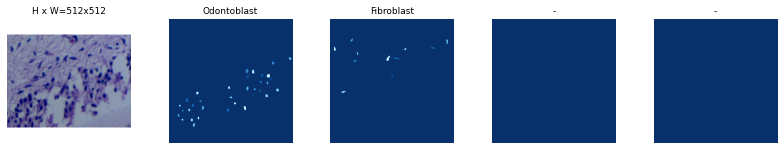

(512, 512, 3)
(512, 512, 38)
11


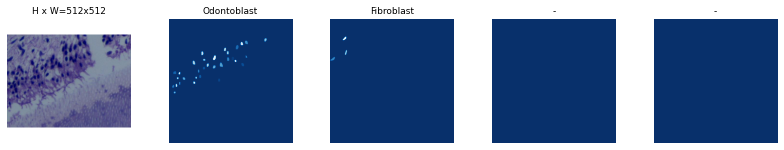

(512, 512, 3)
(512, 512, 31)
12


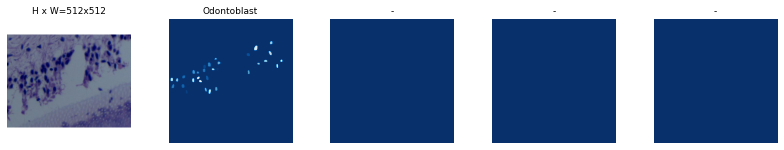

(512, 512, 3)
(512, 512, 13)
13


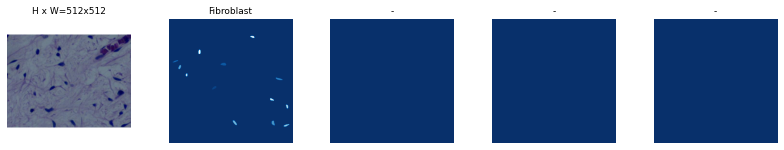

(512, 512, 3)
(512, 512, 36)
14


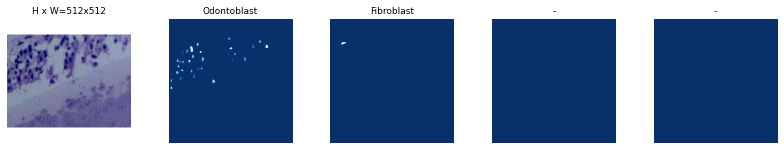

In [ ]:
# Load and display random samples
image_ids = dataset_val.image_ids
for image_id in range (len(image_ids)):
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    print(image.shape)
    print(mask.shape)
    print(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [ ]:
from keras.callbacks import ModelCheckpoint

def callback():
    cb = []
    model_path=os.path.join(MODEL_DIR+"/train",'mask_rcnn_epoch{epoch:02d}.h5')
    checkpoint = ModelCheckpoint(model_path,
                                 save_best_only=True,
                                 mode='min',
                                 monitor='loss',
                                 save_weights_only=True, verbose=1)
    cb.append(checkpoint)
    return cb
    
CB=callback()

#### Creando Modelo

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR+"/train")

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
pretrained_model = os.path.join(MODEL_DIR+"/train", "mask_rcnn.h5")
model.load_weights(pretrained_model, by_name=True)

 #### 1er Entrenamiento


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
history=model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            custom_callbacks=CB,
            epochs=22, 
            layers='heads')

# Save weights

# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR+"/train", "mask_rcnn.h5")
model.keras_model.save_weights(model_path)

#    rpn_class_loss = RPN anchor classifier loss
#    rpn_bbox_loss = RPN bounding box loss graph
#    mrcnn_class_loss = loss for the classifier head of Mask R-CNN
#    mrcnn_bbox_loss = loss for Mask R-CNN bounding box refinement
#    mrcnn_mask_loss = mask binary cross-entropy loss for the masks head




Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/TESIS PREGRADO: SISTEMA DE IDENTIFICACIÓN Y DIFERENCIACIÓN CELULAR/Histologia/Metodologia/MaskRcnn/logs/1erEntrenamientoMRCNNV5_7/fridge20210724T2322/mask_rcnn_fridge_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_

Epoch 1/22
11/11 [==============================] - 934s 85s/step - loss: 1.4401 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 0.9713 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.2028 - val_loss: 1.7524 - val_rpn_class_loss: 0.0640 - val_rpn_bbox_loss: 1.0904 - val_mrcnn_class_loss: 0.0985 - val_mrcnn_bbox_loss: 0.2105 - val_mrcnn_mask_loss: 0.2890




Epoch 00001: loss improved from inf to 1.44005, saving model to /content/drive/My Drive/TESIS PREGRADO: SISTEMA DE IDENTIFICACIÓN Y DIFERENCIACIÓN CELULAR/Histologia/Metodologia/MaskRcnn/logs/1erEntrenamientoMRCNNV5_7/mask_rcnn_epoch01Model3V5_7.h5
Epoch 2/22
11/11 [==============================] - 757s 69s/step - loss: 1.5289 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.0316 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2339 - val_loss: 1.7916 - val_rpn_class_loss: 0.0569 - val_rpn_bbox_loss: 1.1036 - val_mrcnn_class_loss: 0.1755 - val_mrcnn_bbox_loss: 0.2057 - val_mrcnn_mask_loss: 0.2499

Epoch 00002: loss did not improve from 1.44005
Epoch 3/22
11/11 [==============================] - 756s 69s/step - loss: 1.5342 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 1.0129 - mrcnn_class_loss: 0.1180 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.2159 - val_loss: 1.6416 - val_rpn_class_loss: 0.0590 - val_rpn_bbox_loss: 1.0178 - val_mrcnn_class_loss: 0.0841 - val_mrcn

#### Segundo Entrenamiento

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
history=model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            custom_callbacks=CB, 
            epochs=40, 
            layers="all")

# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR+"/train", "mask_rcnn.h5")
model.keras_model.save_weights(model_path)



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/TESIS PREGRADO: SISTEMA DE IDENTIFICACIÓN Y DIFERENCIACIÓN CELULAR/Histologia/Metodologia/MaskRcnn/logs/2doEntrenamientoMRCNNV5_7/fridge20210720T1516/mask_rcnn_fridge_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c    

Epoch 1/40
11/11 [==============================] - 845s 77s/step - loss: 1.5258 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.9686 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2401 - val_loss: 1.7380 - val_rpn_class_loss: 0.0471 - val_rpn_bbox_loss: 1.0844 - val_mrcnn_class_loss: 0.1270 - val_mrcnn_bbox_loss: 0.2149 - val_mrcnn_mask_loss: 0.2647




Epoch 00001: loss improved from inf to 1.52579, saving model to /content/drive/My Drive/TESIS PREGRADO: SISTEMA DE IDENTIFICACIÓN Y DIFERENCIACIÓN CELULAR/Histologia/Metodologia/MaskRcnn/logs/2doEntrenamientoMRCNNV5_7/mask_rcnn_epoch01ModelV5_7.h5
Epoch 2/40
11/11 [==============================] - 660s 60s/step - loss: 1.5628 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.9870 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2375 - val_loss: 1.6686 - val_rpn_class_loss: 0.0551 - val_rpn_bbox_loss: 1.0882 - val_mrcnn_class_loss: 0.0944 - val_mrcnn_bbox_loss: 0.1810 - val_mrcnn_mask_loss: 0.2499

Epoch 00002: loss did not improve from 1.52579
Epoch 3/40
11/11 [==============================] - 663s 60s/step - loss: 1.4691 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.9578 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2138 - val_loss: 1.8589 - val_rpn_class_loss: 0.1236 - val_rpn_bbox_loss: 1.0651 - val_mrcnn_class_loss: 0.1969 - val_mrcnn

## Resultados

In [ ]:
class InferenceConfig(FridgeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
model_path = os.path.join(MODEL_DIR+"/train", "mask_rcnn.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

### Ground Truth Image

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (19,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (19, 4)               min:   22.00000  max:  496.00000  int32
gt_mask                  shape: (512, 512, 19)        min:    0.00000  max:    1.00000  uint8


<Figure size 1440x1440 with 0 Axes>

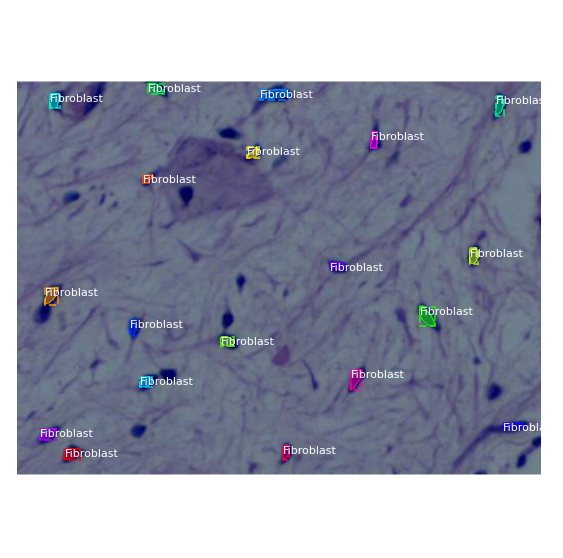

In [ ]:
# Test on a random image
#image_id = random.choice(dataset_val.image_ids)
image_id =2
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
plt.figure(figsize=(20,20))
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(10, 10))

### Predicted Image





Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.08856  max:    0.99771  float32


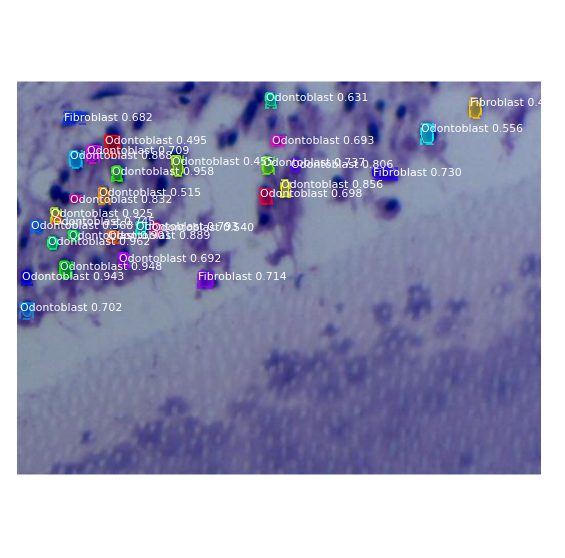

In [ ]:
 original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                            image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1);

r = results[0];
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

### Matriz de Confusion

#### Funciones para matriz

In [ ]:
def get_iou(a, b, epsilon=1e-5):
    """ 
    Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.
    Args: 
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero
    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [ ]:
def gt_pred_lists(gt_class_ids, gt_bboxes, pred_class_ids, pred_bboxes, iou_tresh = 0.5):
    """ 
        Given a list of ground truth and predicted classes and their boxes, 
        this function associates the predicted classes to their gt classes using a given Iou (Iou>= 0.5 for example) and returns 
        two normalized lists of len = N containing the gt and predicted classes, 
        filling the non-predicted and miss-predicted classes by the background class (index 0).
        Args    :
            gt_class_ids   :    list of gt classes of size N1
            pred_class_ids :    list of predicted classes of size N2
            gt_bboxes      :    list of gt boxes [N1, (x1, y1, x2, y2)]
            pred_bboxes    :    list of pred boxes [N2, (x1, y1, x2, y2)]
            
        Returns : 
            gt             :    list of size N
            pred           :    list of size N 
    """
    #dict containing the state of each gt and predicted class (0 : not associated to any other class, 1 : associated to a class)
    gt_class_ids_ = {'state' : [0*i for i in range(len(gt_class_ids))], "gt_class_ids":list(gt_class_ids)}
    pred_class_ids_ = {'state' : [0*i for i in range(len(pred_class_ids))], "pred_class_ids":list(pred_class_ids)}

    #the two lists to be returned
    pred=[]
    gt=[]
    IoU_pred=[]
    IoU_fib=np.array([])
    IoU_odon=np.array([])

    for i, gt_class in enumerate(gt_class_ids_["gt_class_ids"]):
        for j, pred_class in enumerate(pred_class_ids_['pred_class_ids']): 
            #check if the gt object is overlapping with a predicted object
            
            Iou=get_iou(gt_bboxes[i], pred_bboxes[j])
            if pred_class == 1:
                IoU_fib=np.append(IoU_fib,Iou)
            if pred_class == 2:
                IoU_odon=np.append(IoU_odon,Iou)
            IoU_pred.append(Iou)

            if Iou>=iou_tresh:
                #change the state of the gt and predicted class when an overlapping is found
                gt_class_ids_['state'][i] = 1
                pred_class_ids_['state'][j] = 1
                #gt.append(gt_class)
                #pred.append(pred_class)
                
                #chack if the overlapping objects are from the same class
                if (gt_class == pred_class):
                	gt.append(gt_class)
                	pred.append(pred_class)
                #if the overlapping objects are not from the same class 
                else : 
                    gt.append(gt_class)
                    pred.append(pred_class)
                
    #look for objects that are not predicted (gt objects that dont exists in pred objects)
    for i, gt_class in enumerate(gt_class_ids_["gt_class_ids"]):
        if gt_class_ids_['state'][i] == 0:
            gt.append(gt_class)
            pred.append(0)
            #match_id += 1
    #look for objects that are mispredicted (pred objects that dont exists in gt objects)
    for j, pred_class in enumerate(pred_class_ids_["pred_class_ids"]):
        if pred_class_ids_['state'][j] == 0:
            gt.append(0)
            pred.append(pred_class)
    return gt, pred, IoU_pred, IoU_fib, IoU_odon

#### Resultados primer entrenamiento 

In [ ]:
## Evalua todas la imagenes del dataset de Validacion##

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset_val.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    info = dataset_val.image_info[image_id]

    # Run the model
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)


print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.08856  max:    0.99771  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.08856  max:    0.99771  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000

In [ ]:
pred_tot.shape

(574,)

In [ ]:
#Matriz de confusion
from  sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from keras.utils import to_categorical 
cm=confusion_matrix(pred_tot,gt_tot)
cm

array([[  0,  41,  86],
       [159, 174,   2],
       [ 49,   2,  61]])

Text(0.5, 51.0, 'True Label')

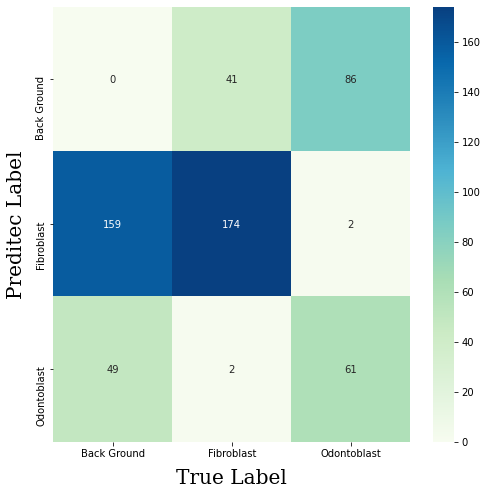

In [ ]:
import matplotlib.pyplot as plt
resultado = pd.DataFrame(cm, index= ['Back Ground','Fibroblast','Odontoblast'],columns = ['Back Ground','Fibroblast','Odontoblast'])
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)
sn.heatmap(resultado, annot=True, linewidths=0, linecolor= 'white',fmt= 'd',cmap="GnBu")

#ax.set_title("Matrix de confusion Modelo 5.4 1er Entrenamiento",fontdict ={'family': 'serif','color': 'black','weight': 'normal','size':20})
ax.set_ylabel("Preditec Label", labelpad=10, fontdict={'family': 'serif','color': 'black','weight': 'normal','size':20})
ax.set_xlabel("True Label", labelpad=10, fontdict={'family': 'serif','color': 'black','weight': 'normal','size':20})

##### Metricas

In [ ]:
y=gt_tot
y_hat=pred_tot

TP,FP,FN,TP_F,FN_F,FP_F,TP_O,FP_O,FN_O = [0]*9

## Fibroblast metrics
for x in range (len(y)):
  if y[x] == 1 and y_hat[x] == 1:
    TP_F += 1
  if y[x] == 1 and y[x] != y_hat[x]:
    FN_F += 1  
  if y_hat[x] == 1 and y[x] == 0:
    FP_F += 1   

print('\n Fibroblastos \n True positive: %d \n False Negative: %d \n False Positive: %d'%(TP_F ,FN_F, FP_F))

## Odontoblast metrics
for x in range (len(y)):
  if y[x] == 2 and y_hat[x] == 2:
    TP_O += 1
  if y[x] == 2 and y[x] != y_hat[x]:
    FN_O += 1  
  if y_hat[x] == 2 and y[x] == 0:
    FP_O += 1   
print('\n Odontoblastos \n True positive: %d \n False Negative: %d \n False Positive: %d'%(TP_O ,FN_O, FP_O))

## System metrics
for x in range (len(y)):
  if y[x] == y_hat[x]:
    TP += 1
  if y[x] != 0 and y[x] != y_hat[x]:
    FN += 1  
  if y[x] == 0:
    FP += 1   
    
print('\n Sistema \n True positive: %d \n False Negative: %d \n False Positive: %d \n'%(TP ,FN, FP))

precision_F=TP_F/(TP_F+FP_F)
recall_F=TP_F/(TP_F+FN_F)
F1_F= (2*precision_F*recall_F)/(precision_F+recall_F)
accuracy_F=TP_F/(TP_F+FN_F+FP_F)
print('\n Metricas de Fibroblastos: \n Accuracy:%f \n Precision:%f  \n Recall:%f  \n F1-Score:%f '%(accuracy_F,precision_F,recall_F,F1_F))

precision_O=TP_O/(TP_O+FP_O)
recall_O=TP_O/(TP_O+FN_O)
F1_O= (2*precision_O*recall_O)/(precision_O+recall_O)
accuracy_O=TP_O/(TP_O+FN_O+FP_O)
print('\n Metricas de Odontoblastos: \n Accuracy:%f \n Precision:%f  \n Recall:%f  \n F1-Score:%f '%(accuracy_O,precision_O,recall_O,F1_O))

precision=TP/(TP+FP)
recall=TP/(TP+FN)
F1= (2*precision*recall)/(precision+recall)
accuracy=TP/(TP+FN+FP)
print('\n Metricas del sistema: \n Accuracy:%f \n Precision:%f  \n Recall:%f  \n F1-Score:%f '%(accuracy,precision,recall,F1))



 Fibroblastos 
 True positive: 174 
 False Negative: 43 
 False Positive: 159

 Odontoblastos 
 True positive: 61 
 False Negative: 88 
 False Positive: 49

 Sistema 
 True positive: 235 
 False Negative: 131 
 False Positive: 208 


 Metricas de Fibroblastos: 
 Accuracy:0.462766 
 Precision:0.522523  
 Recall:0.801843  
 F1-Score:0.632727 

 Metricas de Odontoblastos: 
 Accuracy:0.308081 
 Precision:0.554545  
 Recall:0.409396  
 F1-Score:0.471042 

 Metricas del sistema: 
 Accuracy:0.409408 
 Precision:0.530474  
 Recall:0.642077  
 F1-Score:0.580964 


#####mAP


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.

APs = []

for image_id in range (len(dataset_val.image_ids)):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))
print(APs)

mAP:  0.6630069329320007
[0.7301136556674135, 0.7342013888888889, 0.8789473593235015, 0.915617715089749, 0.8231495934050709, 0.6508828294528856, 0.9054633666094162, 0.7335267509120741, 0.5512622254303633, 0.41875978208623177, 0.4450373259532933, 0.4492653339559924, 0.5569680431499857, 0.8241758282695497, 0.3277327957855947]


#### Resultados Segundo  entrenamiento 

In [ ]:
## Evalua todas la imagenes del dataset de Validacion##

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset_val.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    info = dataset_val.image_info[image_id]

    # Run the model
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)


print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.08856  max:    0.99771  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.08856  max:    0.99771  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000

In [ ]:
pred_tot.shape

(425,)

In [ ]:
#Matriz de confusion
from  sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from keras.utils import to_categorical 
cm=confusion_matrix(pred_tot,gt_tot)
cm

array([[  0,  29,  40],
       [ 36, 186,   2],
       [ 22,   1, 109]])

Text(0.5, 51.0, 'True Label')

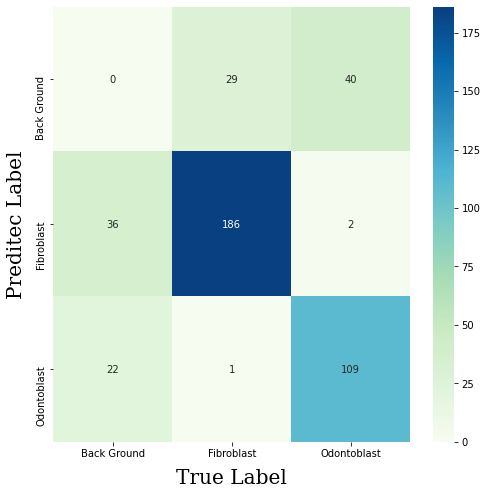

In [ ]:
import matplotlib.pyplot as plt
resultado = pd.DataFrame(cm, index= ['Back Ground','Fibroblast','Odontoblast'],columns = ['Back Ground','Fibroblast','Odontoblast'])
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)
sn.heatmap(resultado, annot=True, linewidths=0, linecolor= 'white',fmt= 'd',cmap="GnBu")

#ax.set_title("Matrix de confusion Modelo 5.4 1er Entrenamiento",fontdict ={'family': 'serif','color': 'black','weight': 'normal','size':20})
ax.set_ylabel("Preditec Label", labelpad=10, fontdict={'family': 'serif','color': 'black','weight': 'normal','size':20})
ax.set_xlabel("True Label", labelpad=10, fontdict={'family': 'serif','color': 'black','weight': 'normal','size':20})

##### Metricas

In [ ]:
y=gt_tot
y_hat=pred_tot

TP,FP,FN,TP_F,FN_F,FP_F,TP_O,FP_O,FN_O = [0]*9

## Fibroblast metrics
for x in range (len(y)):
  if y[x] == 1 and y_hat[x] == 1:
    TP_F += 1
  if y[x] == 1 and y[x] != y_hat[x]:
    FN_F += 1  
  if y_hat[x] == 1 and y[x] == 0:
    FP_F += 1   

print('\n Fibroblastos \n True positive: %d \n False Negative: %d \n False Positive: %d'%(TP_F ,FN_F, FP_F))

## Odontoblast metrics
for x in range (len(y)):
  if y[x] == 2 and y_hat[x] == 2:
    TP_O += 1
  if y[x] == 2 and y[x] != y_hat[x]:
    FN_O += 1  
  if y_hat[x] == 2 and y[x] == 0:
    FP_O += 1   
print('\n Odontoblastos \n True positive: %d \n False Negative: %d \n False Positive: %d'%(TP_O ,FN_O, FP_O))

## System metrics
for x in range (len(y)):
  if y[x] == y_hat[x]:
    TP += 1
  if y[x] != 0 and y[x] != y_hat[x]:
    FN += 1  
  if y[x] == 0:
    FP += 1   
    
print('\n Sistema \n True positive: %d \n False Negative: %d \n False Positive: %d \n'%(TP ,FN, FP))

precision_F=TP_F/(TP_F+FP_F)
recall_F=TP_F/(TP_F+FN_F)
F1_F= (2*precision_F*recall_F)/(precision_F+recall_F)
accuracy_F=TP_F/(TP_F+FN_F+FP_F)
print('\n Metricas de Fibroblastos: \n Accuracy:%f \n Precision:%f  \n Recall:%f  \n F1-Score:%f '%(accuracy_F,precision_F,recall_F,F1_F))

precision_O=TP_O/(TP_O+FP_O)
recall_O=TP_O/(TP_O+FN_O)
F1_O= (2*precision_O*recall_O)/(precision_O+recall_O)
accuracy_O=TP_O/(TP_O+FN_O+FP_O)
print('\n Metricas de Odontoblastos: \n Accuracy:%f \n Precision:%f  \n Recall:%f  \n F1-Score:%f '%(accuracy_O,precision_O,recall_O,F1_O))

precision=TP/(TP+FP)
recall=TP/(TP+FN)
F1= (2*precision*recall)/(precision+recall)
accuracy=TP/(TP+FN+FP)
print('\n Metricas del sistema: \n Accuracy:%f \n Precision:%f  \n Recall:%f  \n F1-Score:%f '%(accuracy,precision,recall,F1))



 Fibroblastos 
 True positive: 186 
 False Negative: 30 
 False Positive: 36

 Odontoblastos 
 True positive: 109 
 False Negative: 42 
 False Positive: 22

 Sistema 
 True positive: 295 
 False Negative: 72 
 False Positive: 58 


 Metricas de Fibroblastos: 
 Accuracy:0.738095 
 Precision:0.837838  
 Recall:0.861111  
 F1-Score:0.849315 

 Metricas de Odontoblastos: 
 Accuracy:0.630058 
 Precision:0.832061  
 Recall:0.721854  
 F1-Score:0.773050 

 Metricas del sistema: 
 Accuracy:0.694118 
 Precision:0.835694  
 Recall:0.803815  
 F1-Score:0.819444 


#####mAP


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.

image_ids = np.random.choice(dataset_val.image_ids, 9)
APs = []

for image_id in range (len(dataset_val.image_ids)):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))
print(APs)

# Modelo Paso a Paso


###Paso 1: Region Proposal Network
The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

### 1.b RPN Predictions
Here we run the RPN graph and display its predictions.

In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    original_image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

In [ ]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(original_image.shape)
anchors = utils.denorm_boxes(anchors, original_image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    original_image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (65472, 4)            min:  -45.00000  max:  511.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min:  -10.41667  max:    5.63006  float64
positive_anchors         shape: (15, 4)               min:    5.00000  max:  464.00000  int32
negative_anchors         shape: (49, 4)               min:   -8.00000  max:  506.00000  int32
neutral anchors          shape: (65408, 4)            min:  -45.00000  max:  511.00000  int32
refined_anchors          shape: (15, 4)               min:    0.00000  max:  447.00000  float32


### Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.


2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.


In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([original_image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    0.99708  float32
probs                    shape: (1, 2000, 3)          min:    0.00000  max:    0.99999  float32
deltas                   shape: (1, 2000, 3, 4)       min:   -3.64068  max:    4.07854  float32
masks                    shape: (1, 400, 28, 28, 3)   min:    0.00001  max:    1.00000  float32
detections               shape: (1, 400, 6)           min:    0.00000  max:    2.00000  float32


44 detections: ['Fibroblast' 'Fibroblast' 'Fibroblast' 'Odontoblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Odontoblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Odontoblast' 'Odontoblast' 'Odontoblast']


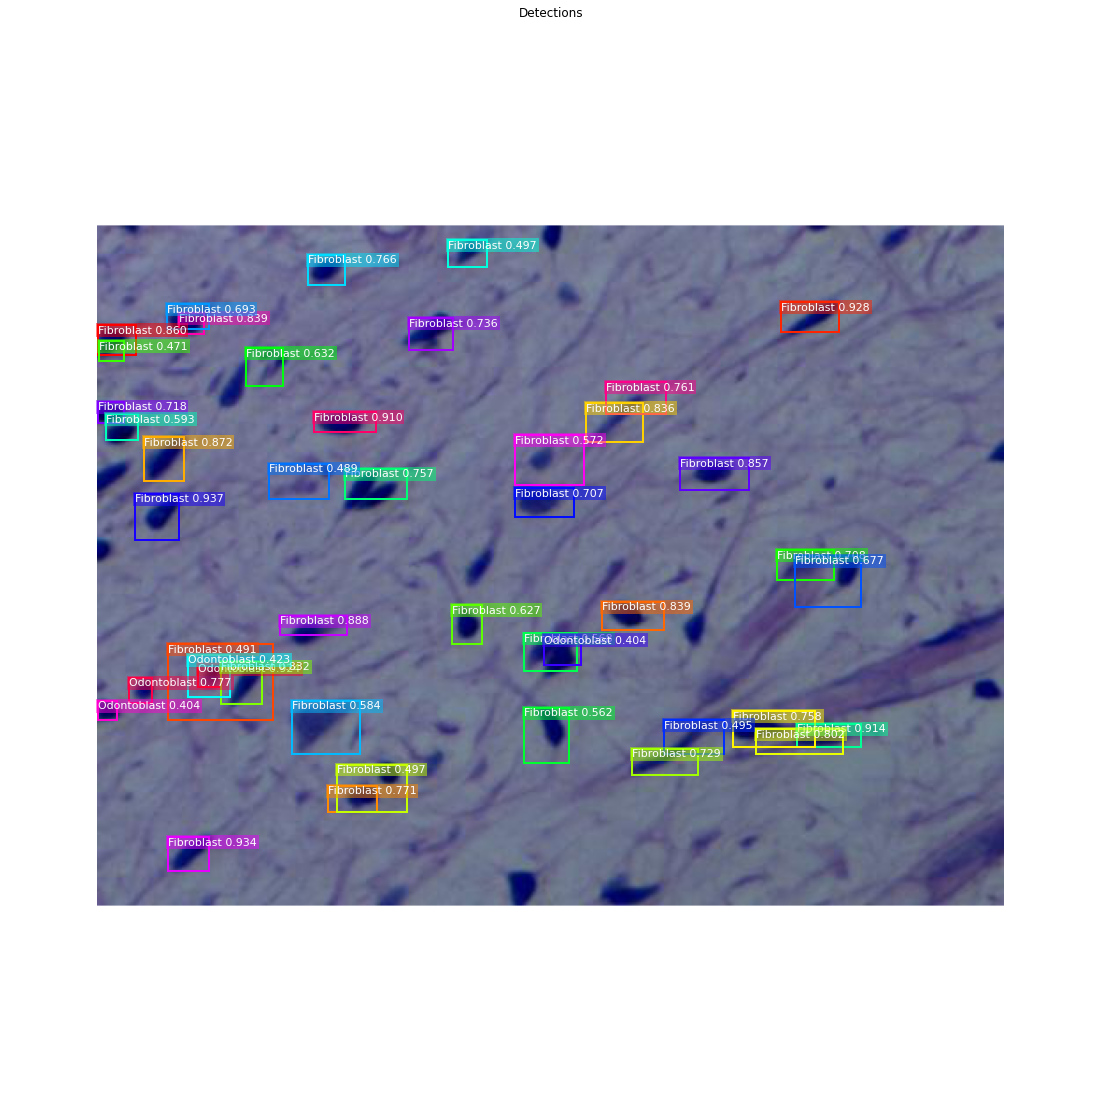

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_val.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    original_image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], original_image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_val.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2000 Valid proposals out of 2000
125 Positive ROIs
[('BG', 1875), ('Fibroblast', 114), ('Odontoblast', 11)]


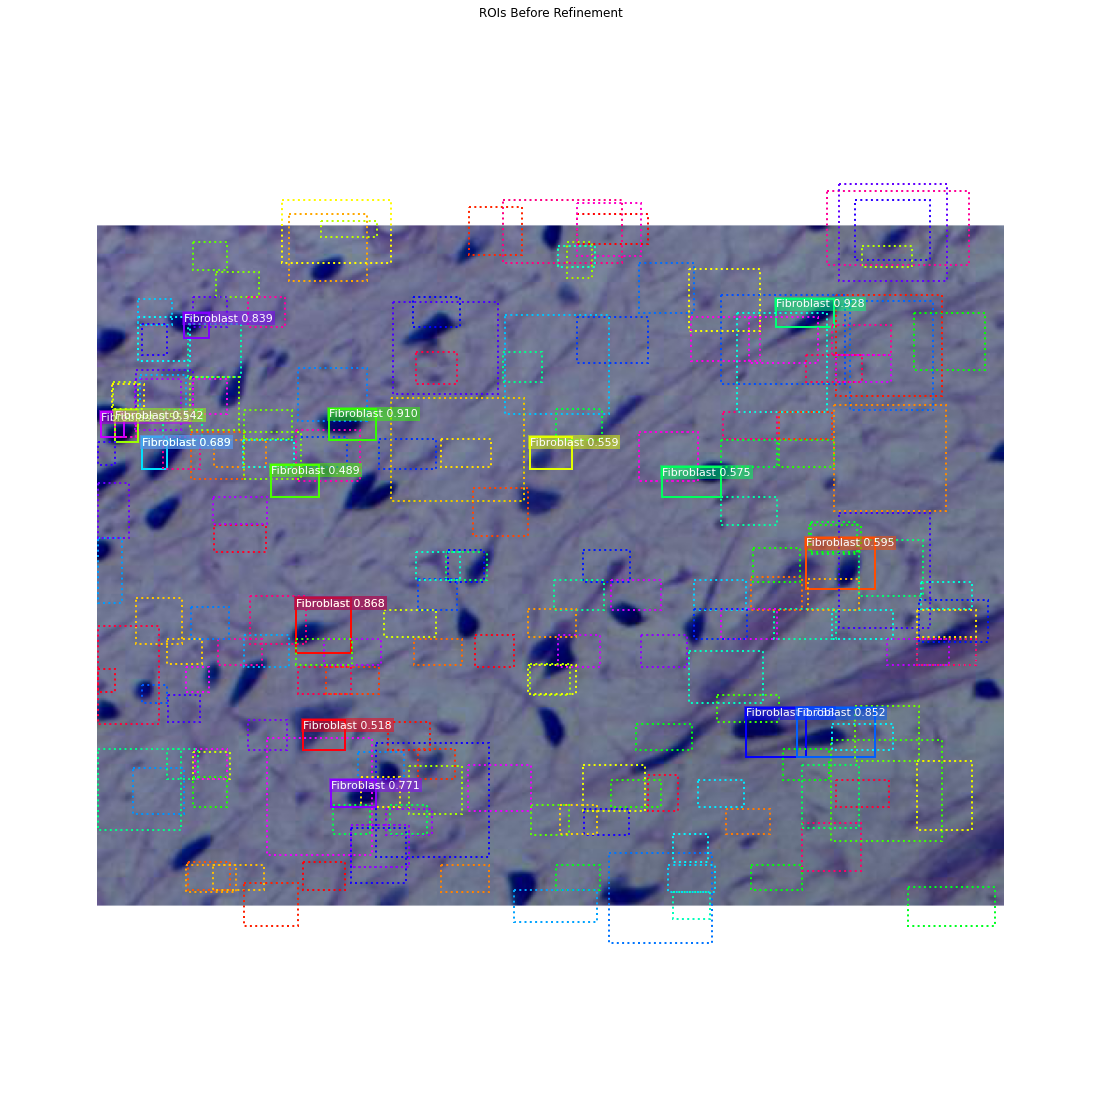

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    original_image,
    boxes=utils.denorm_boxes(proposals[ixs], original_image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -2.83405  max:    4.07854  float32
refined_proposals        shape: (2000, 4)             min:   -0.00298  max:    0.99653  float32


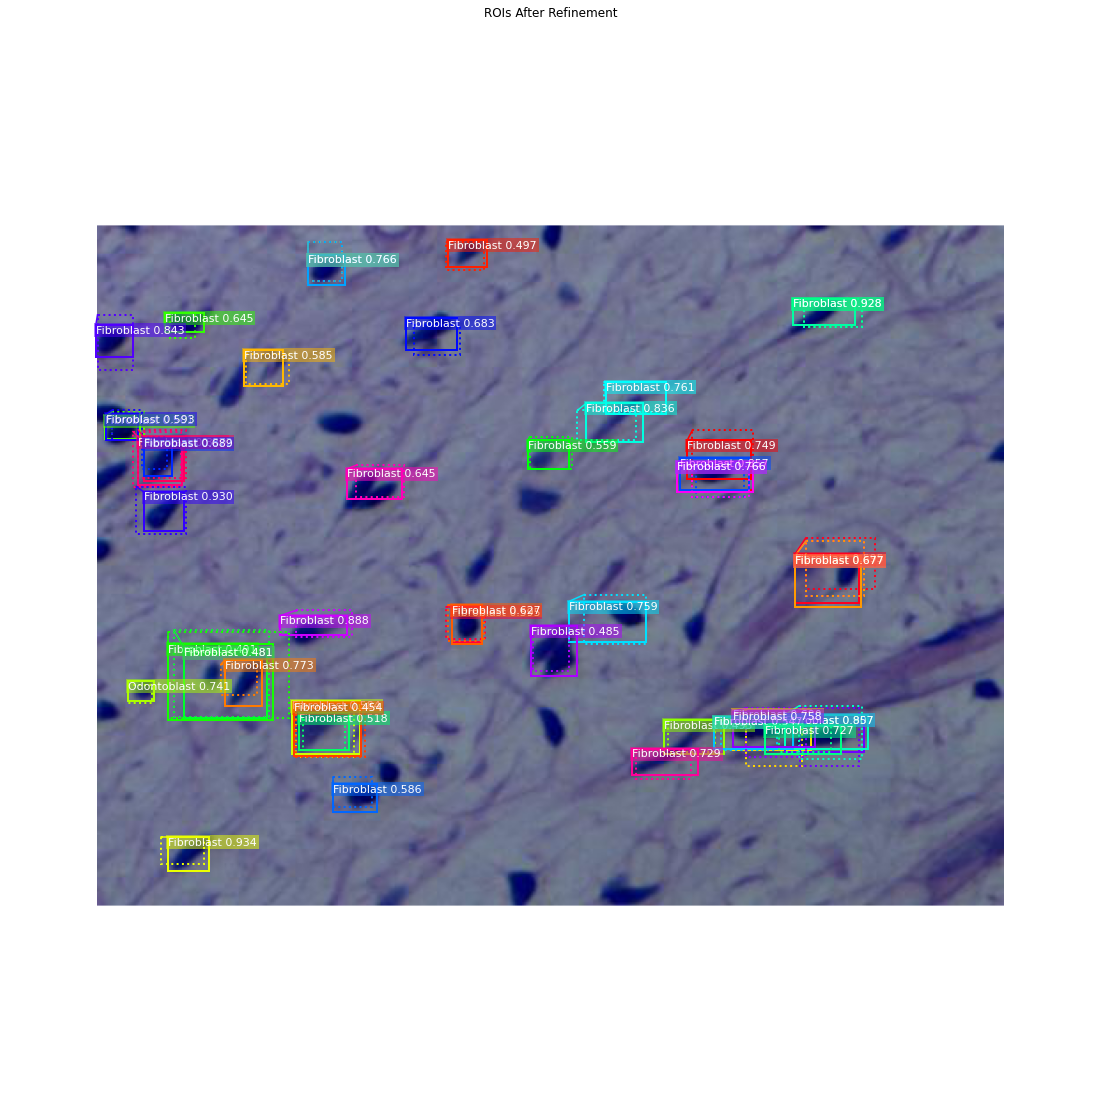

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 50
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    original_image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], original_image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], original_image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 125 detections:
[  18   73   76   79   95  110  117  133  162  181  185  190  211  219
  221  227  242  248  249  251  256  301  314  326  327  340  345  394
  425  432  433  441  449  455  458  459  480  492  499  504  516  537
  555  564  571  573  575  585  594  599  612  617  622  667  669  677
  685  691  707  712  721  727  729  754  770  772  778  816  828  842
  871  876  908  911  931  937  942 1046 1079 1101 1102 1105 1107 1166
 1205 1221 1240 1283 1292 1312 1315 1339 1342 1345 1357 1367 1454 1475
 1497 1498 1519 1527 1551 1597 1613 1619 1637 1684 1691 1741 1783 1793
 1810 1847 1848 1850 1899 1905 1921 1936 1973 1975 1977 1987 1992]


In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 125:
[  18   73   76   79   95  110  117  133  162  181  185  190  211  219
  221  227  242  248  249  251  256  301  314  326  327  340  345  394
  425  432  433  441  449  455  458  459  480  492  499  504  516  537
  555  564  571  573  575  585  594  599  612  617  622  667  669  677
  685  691  707  712  721  727  729  754  770  772  778  816  828  842
  871  876  908  911  931  937  942 1046 1079 1101 1102 1105 1107 1166
 1205 1221 1240 1283 1292 1312 1315 1339 1342 1345 1357 1367 1454 1475
 1497 1498 1519 1527 1551 1597 1613 1619 1637 1684 1691 1741 1783 1793
 1810 1847 1848 1850 1899 1905 1921 1936 1973 1975 1977 1987 1992]


#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_val.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Fibroblast            : [  18   73   76   79   95  110  117  133  185  190  211  219  221  227
  242  248  249  251  256  301  314  326  327  340  345  394  425  432
  433  441  455  458  459  480  492  499  504  516  537  555  564  571
  573  575  585  594  599  612  617  622  667  669  677  685  691  707
  721  727  729  754  772  778  816  828  842  871  876  908  911  931
  937  942 1046 1079 1101 1102 1105 1107 1205 1221 1240 1283 1292 1312
 1315 1339 1342 1345 1367 1454 1475 1497 1498 1519 1527 1551 1597 1613
 1619 1637 1684 1691 1741 1783 1793 1847 1848 1850 1899 1921 1973 1975
 1977 1992] -> [ 778 1519 1345 1637  816  727  117 1975 1312 1847  842 1046  185 1475
  251  685 1899 1527   79  480  340  571 1498 1342 1597  459  190  707
 1973  248  327  677  110  301  326  691 1551  617 1921]
Odontoblast           : [ 162  181  449  712  770 1166 1357 1810 1905 1936 1987] -> [1357  712  449 1987 1936]

Kept after per-class NMS: 44
[  79  110  117  185  190  248  251  301  326  327  3

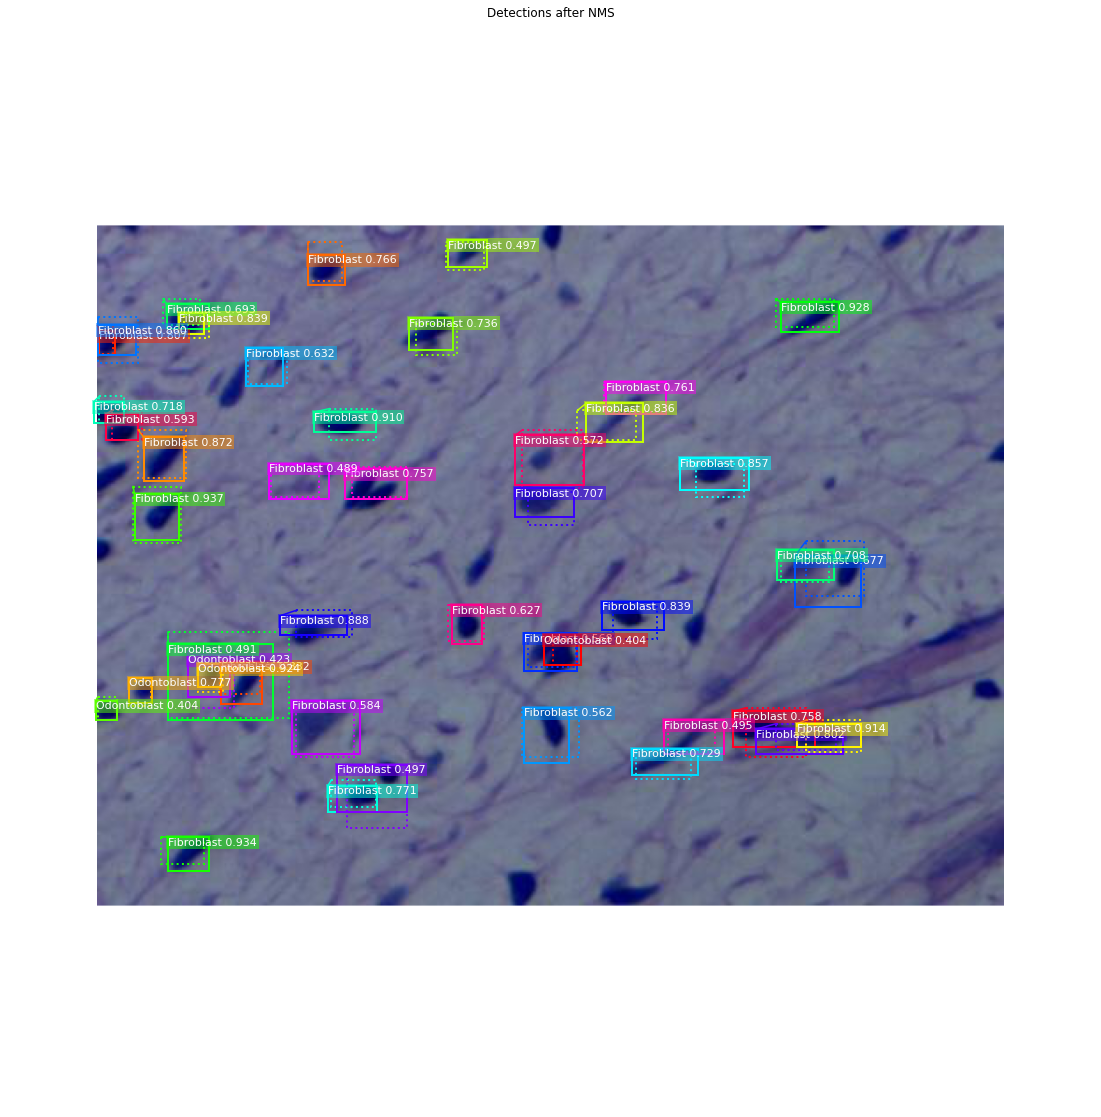

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    original_image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], original_image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], original_image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

### Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

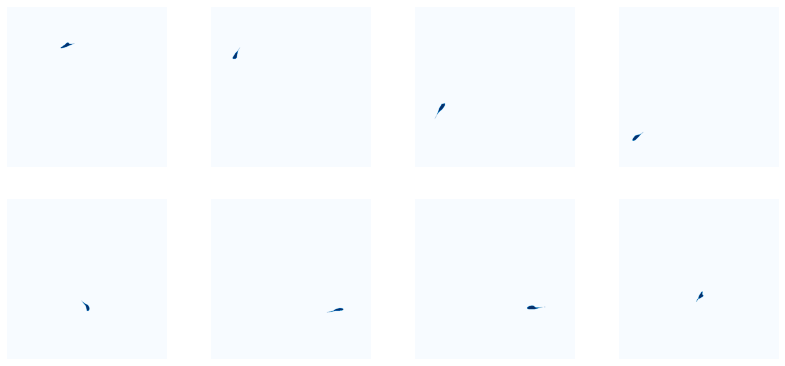

In [ ]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([original_image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

detections               shape: (1, 400, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 400, 28, 28, 3)   min:    0.00001  max:    1.00000  float32
44 detections: ['Fibroblast' 'Fibroblast' 'Fibroblast' 'Odontoblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Odontoblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast' 'Fibroblast'
 'Fibroblast' 'Odontoblast' 'Odontoblast' 'Odontoblast']


In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], original_image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], original_image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (44, 28, 28)          min:    0.00002  max:    0.99999  float32
det_masks                shape: (44, 512, 512)        min:    0.00000  max:    1.00000  bool


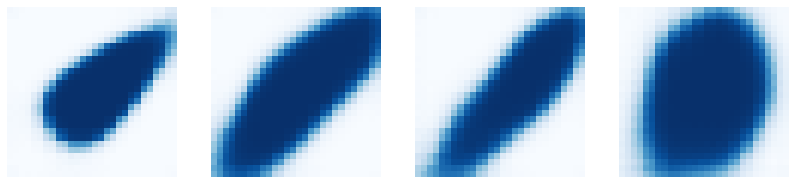

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

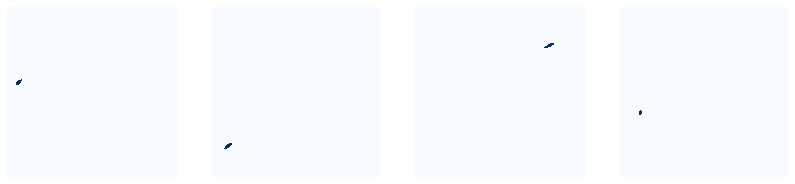

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

### Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([original_image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   34.86633  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:   30.86335  float32
rpn_bbox                 shape: (1, 65472, 4)         min:   -6.14884  max:   24.35558  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    0.99708  float32


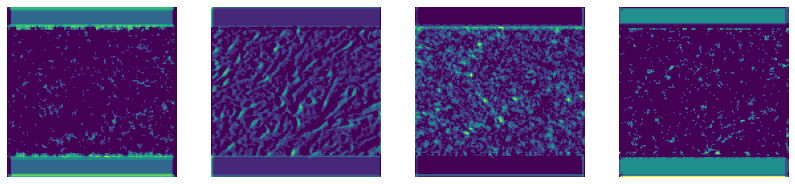

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)